# This is the demo of SSGANs on MOG (mixture of gaussian) 

Load the needed package

# Import and libraries

In [1]:
%matplotlib inline
import os
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from mmd_metric import polynomial_mmd

# Classes for SSGAN

In [2]:
#######G network

class G_guassian(nn.Module):

    def __init__(self, nz):
        super(G_guassian, self).__init__()

        self.decode = nn.Sequential(
            nn.Linear(nz,10),
            nn.Tanh(),
            nn.Linear(10, 10),
            nn.Tanh(),
            nn.Linear(10, 1),
        )

        self.__initialize_weights()

    def forward(self, z, output=None):

        output = self.decode(z)

        return output

    def __initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0.0, 0.02)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.normal_(1.0, 0.02)
                m.bias.data.fill_(0)
                

#####D network
class D_guassian(nn.Module):

    def __init__(self, num_classes=4, MS=False, LA=False):
        super(D_guassian, self).__init__()

        self.MS = MS
        self.LA = LA

        self.encode = nn.Sequential(
            nn.Linear(1, 10),
            nn.Tanh(),
            nn.Linear(10, 10),
            nn.Tanh(),
        )
        self.gan_linear = nn.Linear(10, 1)
        self.ss_linear = nn.Linear(10, num_classes)
        self.ms_linear = nn.Linear(10, num_classes+1)
        self.la_linear = nn.Linear(10, num_classes*2)

        self.sigmoid = nn.Sigmoid()
        self.__initialize_weights()

    def forward(self, input):

        x = self.encode(input)
        
        ss = self.ss_linear(x)
        ms = self.ms_linear(x)
        la = self.la_linear(x)
        
        s = self.gan_linear(x)
        s = self.sigmoid(s)
        
        return s.squeeze(1), ss.squeeze(1), ms.squeeze(1), la.squeeze(1)

    def __initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0.0, 0.02)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.normal_(1.0, 0.02)
                m.bias.data.fill_(0)

# Helper functions to plot the results

In [3]:
def plot_density(flights,binwidth=0.1):
    ax = plt.subplot(1,1,1)

    # Draw the plot
    ax.hist(flights, bins=int(180 / binwidth),
            color='blue', edgecolor='black')

    # Title and labels
    ax.set_title('Histogram with Binwidth = %d' % binwidth, size=30)
    ax.set_xlabel('Delay (min)', size=22)
    ax.set_ylabel('Flights', size=22)

    plt.tight_layout()
    plt.show()

# Runner

In [ ]:
def train(data,nz,G,D,optd,optg,dis,name,lbd=1):
    for _ in range(100):
        for i in range(100):

            #####D step
            for _ in range(2):
                real_data = torch.cat(
                    [data[128 * i:128 * i + 128], data[128 * i:128 * i + 128] + dis, 
                     data[128 * i:128 * i + 128] + 2*dis, data[128 * i:128 * i + 128] + 3*dis],
                    dim=0).unsqueeze(dim=1)
                real_label = torch.cat([torch.ones(128).long()*0, torch.ones(128).long()*1, torch.ones(128).long()*2, torch.ones(128).long()*3], dim=0)

                ###D
                d_real, ss_real, ms_real, la_real = D(real_data)

                z = torch.randn(128, nz)
    
                fake_data = G(z)
                fake_data = torch.cat([fake_data, fake_data + dis, fake_data + 2*dis, fake_data + 3*dis], dim=0)
                fake_label = torch.cat([torch.ones(128).long()*0, torch.ones(128).long()*1, torch.ones(128).long()*2, torch.ones(128).long()*3], dim=0)
                d_fake, ss_fake, ms_fake, la_fake = D(fake_data)

                if name == 'SSGAN':
                    D_loss = F.binary_cross_entropy(d_real[:128], torch.ones(128)) + F.binary_cross_entropy(d_fake[:128], torch.zeros(128))
                    D_loss += lbd * F.cross_entropy(ss_real, real_label)
                elif name == 'SSGAN-MS':
                    D_loss = F.binary_cross_entropy(d_real[:128], torch.ones(128)) + F.binary_cross_entropy(d_fake[:128], torch.zeros(128))
                    D_loss += lbd * (F.cross_entropy(ms_real, real_label) + F.cross_entropy(ms_fake, torch.ones(128*4).long()*4))
                elif name == 'SSGAN-LA':
#                     D_loss = F.binary_cross_entropy(d_real[:128], torch.ones(128)) + F.binary_cross_entropy(d_fake[:128], torch.zeros(128))
                    D_loss = lbd * (F.cross_entropy(la_real, real_label * 2) + F.cross_entropy(la_fake, fake_label * 2 + 1))

                optd.zero_grad()
                D_loss.backward()
                optd.step()

            #####G step
            if i % 10 == 0:
                z = torch.randn(128, nz)
                fake_data = G(z)
                fake_data = torch.cat([fake_data, fake_data + dis, fake_data + 2*dis, fake_data + 3*dis], dim=0)
                real_label = torch.cat([torch.ones(128).long()*0, torch.ones(128).long()*1, torch.ones(128).long()*2, torch.ones(128).long()*3], dim=0)
                d_fake, ss_fake, ms_fake, la_fake = D(fake_data)

                if name == 'SSGAN':
                    G_loss = F.binary_cross_entropy(d_fake[:128], torch.ones(128))
                    G_loss += lbd * F.cross_entropy(ss_fake, real_label)
                elif name == 'SSGAN-MS':
                    G_loss = F.binary_cross_entropy(d_fake[:128], torch.ones(128))
                    G_loss += lbd * (F.cross_entropy(ms_fake, real_label) - F.cross_entropy(ms_fake, torch.ones(128*4).long()*4))
                elif name == 'SSGAN-LA':
#                     G_loss = F.binary_cross_entropy(d_fake[:128], torch.ones(128))
                    G_loss = lbd * (F.cross_entropy(la_fake, real_label * 2) - F.cross_entropy(la_fake, real_label * 2 + 1))

                optg.zero_grad()
                G_loss.backward()
                optg.step()

# Visualize and evaluation

Running the 1-D MOG toy experiments of different distance between different gaussian components. Cost about 10 min in 1080ti

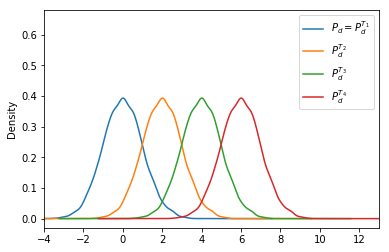

In [ ]:
######create folder to save the result
distance = 2
if os.path.exists(os.path.join('MOG','1D', str(distance) + '_1D')):
    pass
else:
    os.makedirs(os.path.join('MOG','1D', str(distance) + '_1D'))
save_path = os.path.join('MOG','1D', str(distance) + '_1D')

######Generate MOG data of different mean and variance
data1 = torch.randn(12800)
data2 = data1 + distance
data3 = data2 + distance
data4 = data3 + distance

df1 = pd.DataFrame()
df2 = pd.DataFrame()

df1['score_{0}'.format(0)] = data1.cpu().numpy()
df1['score_{0}'.format(1)] = data2.cpu().numpy()
df1['score_{0}'.format(2)] = data3.cpu().numpy()
df1['score_{0}'.format(3)] = data4.cpu().numpy()
r_data = torch.cat([data1, data2, data3, data4], dim=0).cpu().numpy()
df2['score_{0}'.format(3)] = r_data
np.save(save_path+'/o_data',r_data)

######Plot the distribution of original data
fig, ax = plt.subplots(1, 1)
for s in df1.columns:
    df1[s].plot(kind='kde')

# for s in df2.columns:
#     df2[s].plot(style='--',kind='kde')
plt.xlim((-4, 9 + distance * 2))
plt.ylim((-0.03, 0.68))
ax.legend([r"$P_d=P_d^{T_1}$", r"$P_d^{T_2}$", r"$P_d^{T_3}$", r"$P_d^{T_4}$"])
# plt.title('Original')
fig.savefig(save_path + '/original.eps')

# Build Network

In [ ]:
# name = "SSGAN"
name = "SSGAN-MS"
# name = "SSGAN-LA"
        
#####Bulding network
nz = 2
G = G_guassian(nz=nz)

D = D_guassian(num_classes=4)

optg = optim.Adam(G.parameters(), lr=0.001,
                      betas=(0.5, 0.999))
optd = optim.Adam(D.parameters(), lr=0.001,
                      betas=(0.5, 0.999))

In [ ]:
#####Train network
train(data1,nz,G,D,optd,optg,dis=distance,name=name,lbd=1)
print('Training finished')

#####Sample data from Generator
z = torch.randn(10000, nz)
label = torch.zeros(10000).long()  # torch.LongTensor(10000).random_(2).cuda()#
data_g = G(z=z).squeeze().cpu().detach()

df1 = pd.DataFrame()
df2 = pd.DataFrame()

df1['score_{0}'.format(0)] = data_g.numpy()
df1['score_{0}'.format(1)] = (data_g + distance).numpy()
df1['score_{0}'.format(2)] = (data_g + distance*2).numpy()
df1['score_{0}'.format(3)] = (data_g + distance*3).numpy()
g_data = torch.cat([data_g, data_g + distance, data_g + distance*2, data_g + distance*3], dim=0).numpy()
df2['score_{0}'.format(3)] = g_data

#####Plot generated conditional distribution
fig, ax = plt.subplots(1, 1)
for s in df1.columns:
    df1[s].plot(kind='kde')

# for s in df2.columns:
#     df2[s].plot(style='--',kind='kde')

plt.xlim((-4, 9 + distance * 2))
plt.ylim((-0.03, 0.68))
ax.legend([r"$P_g=P_g^{T_1}$", r"$P_g^{T_2}$", r"$P_g^{T_3}$", r"$P_g^{T_4}$"])
# plt.title(name)
fig.savefig(save_path + '/'+name+'.eps')

# Evaluate the MMD distance between true data and generated data

In [ ]:
mean0_0,var0_0 = polynomial_mmd(np.expand_dims(data_g.numpy(), axis=1), np.expand_dims(data1.cpu().numpy(),axis=1))
print('the distance is : ', mean0_0)